In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image as Image

import scipy
import scipy.misc
import scipy.cluster

from collections import defaultdict

%matplotlib inline
matplotlib.rcParams['font.family'] = 'sans-serif'

In [2]:
# Reference to functions in this cell:
# notebook_for_option2_homework_week02.ipynb, 2020 Spring DataViz class material
# provided by instructor, Jill Naiman

# NOTE: I am not expecting you to know how to write these on your own!
def quantizetopalette(silf, palette, dither=False):
    """Convert an RGB or L mode image to use a given P image's palette."""
    # refs:
    # [1] https://stackoverflow.com/questions/29433243/convert-image-to-specific-palette-using-pil-without-dithering

    silf.load()

    # use palette from reference image
    palette.load()
    if palette.mode != "P":
        raise ValueError("bad mode for palette image")
    if silf.mode != "RGB" and silf.mode != "L":
        raise ValueError(
            "only RGB or L mode images can be quantized to a palette"
            )
    im = silf.im.convert("P", 1 if dither else 0, palette.im)
    # the 0 above means turn OFF dithering

    # Later versions of Pillow (4.x) rename _makeself to _new
    try:
        return silf._new(im)
    except AttributeError:
        return silf._makeself(im)


def convert_image(image, ncolors = 8):
    # refs:
    # [1]: https://stackoverflow.com/questions/3241929/python-find-dominant-most-common-color-in-an-image
    image = image.convert('RGB') # can't use alpha channel
    NUM_CLUSTERS = ncolors # unnecessary re-naming
    
    ar = np.array(image) # to data
    
    shape = ar.shape
    ar = ar.reshape(np.product(shape[:2]), shape[2]).astype(float)

    print('finding ' + str(ncolors) + ' most common colors.  Note, if "ncolors" is large, this can take a while...')
    codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
    print('Done finding colors! cluster centres in RGB:\n', codes)

    vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
    counts, bins = np.histogram(vecs, len(codes))    # count occurrences
    
    # into a 256 palette, integer types
    reds = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,0])).astype('int')
    greens = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,1])).astype('int')
    blues = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,2])).astype('int')

    # palette formatting:
    myPalette = []
    for i in range(256):
        myPalette.extend( (reds[i],greens[i],blues[i]))
        
    palimage = Image.new('P', (16, 16)) # placeholder image
    palimage.putpalette(myPalette)
    newimage = quantizetopalette(image, palimage, dither=False)
    newimage = newimage.convert('RGB')
    return newimage, codes

# similar to above, but allows you to import your own RGB sequence
def convert_image_specific(image, colors = [ [255, 255, 255], [255, 0, 0], [0,0,255], [0, 0, 0] ]):
    image = image.convert('RGB') # can't use alpha channel
    NUM_CLUSTERS = len(colors) # unnecessary re-naming
    codes = np.array(colors) # unnecessary renaming
    
    # into a 256 palette, integer types
    reds = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,0])).astype('int')
    greens = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,1])).astype('int')
    blues = np.round(np.interp(np.linspace(0,255,256), np.linspace(0,NUM_CLUSTERS-1,NUM_CLUSTERS), codes[:,2])).astype('int')

    # palette formatting:
    myPalette = []
    for i in range(256):
        myPalette.extend( (reds[i],greens[i],blues[i]))
        
    palimage = Image.new('P', (16, 16)) # placeholder image
    palimage.putpalette(myPalette)
    newimage = quantizetopalette(image, palimage, dither=False)
    newimage = newimage.convert('RGB')
    return newimage, codes

In [3]:
# a function for plotting out colors in images
def plot_color_in_image(im_data_list):
    data_for_draw = defaultdict(dict)
    c = 0
    for im_data in im_data_list:
        c += 1
        
        data_for_draw[c]['im_data'] = im_data
        data_for_draw[c]['npix_color'] = []
        data_for_draw[c]['color_label'] = []
        data_for_draw[c]['color_values'] = []

        uniuqe_colors = np.unique(im_data.reshape(-1, im_data.shape[2]), axis=0)
        color_count = 0
        for icolor, rgba in enumerate(uniuqe_colors): # 'enumerate' count up color entries and their values
            # print(icolor, rgba)
            # count pixels with rgba combination

            # step 1: mask out pixels at a particular color
            reds_mask = im_data[:,:,0] == rgba[0] # R
            greens_mask = im_data[:,:,1] == rgba[1] # G
            blues_mask = im_data[:,:,2] == rgba[2] # B

            pixel_mask = None
            if len(rgba) == 4:
                alpha_mask = im_data[:,:,3] == rgba[3] # A
                pixel_mask = reds_mask & greens_mask & blues_mask & alpha_mask
            else:
                pixel_mask = reds_mask & greens_mask & blues_mask

            if pixel_mask is None:
                raise ValueError(
                    "something WRONG with your pixel_mask!"
                    )
            else:
                # step 2: count up all pixels
                n_pix = len(im_data[pixel_mask])
                
                data_for_draw[c]['npix_color'].append(n_pix)
                data_for_draw[c]['color_label'].append('Color #'+ str(c) + '-' + str(icolor))
                data_for_draw[c]['color_values'].append(rgba/255)       
    
    fig, ax = plt.subplots(3, 2, figsize = (12, 16)) # 3 row, 2 cols of figs
    for k, v in data_for_draw.items():

        myBarChart = ax[k-1,0].bar(v['color_label'], v['npix_color']) # plot bar at col_0
        ax[k-1,1].imshow(v['im_data']) # plot bar at plot bar at col_1

        # set color of each bar
        for i in range(len(myBarChart)):
            myBarChart[i].set_color(v['color_values'][i])
            myBarChart[i].set_edgecolor('black')
        
        ax[k-1,0].set_xlabel('Distribution of Colors in Image '+str(k), size=12)
        ax[k-1,1].set_xlabel('Image '+str(k), size=12)
        
    plt.suptitle('Colors in Images', fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()
    

# Image 1

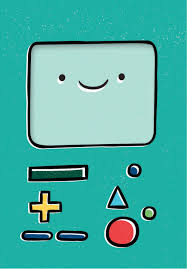

In [4]:
im1 = Image.open('/data/BMO.jpeg')
im1

In [5]:
im1_data = np.array(im1)
im1_data.shape

(269, 187, 3)

In [6]:
#im1_data

In [7]:
# number of unique colors in im1
im1_unique_color = np.unique(im1_data.reshape(-1, im1_data.shape[2]), axis=0)
print('Number of unique colors:', im1_unique_color.shape[0])
print('Number of channels:', im1_unique_color.shape[1])
im1_unique_color

Number of unique colors: 8207
Number of channels: 3


array([[  0,   0,   0],
       [  0,   0,   2],
       [  0,   0,   4],
       ...,
       [255, 254, 255],
       [255, 255, 234],
       [255, 255, 241]], dtype=uint8)

finding 5 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[ 36.20015699  83.63736264  84.37598116]
 [ 31.19814146 176.4034454  165.25667624]
 [  7.28134172   6.69895178   8.42222222]
 [201.571      120.153       95.986     ]
 [177.98913454 219.76367615 211.58628235]]


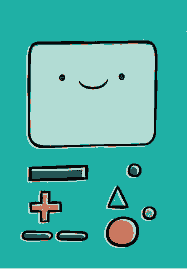

In [8]:
# down sample image
new_im1, new_rgbs1 = convert_image(im1, ncolors = 5)
new_im1

# Image 2

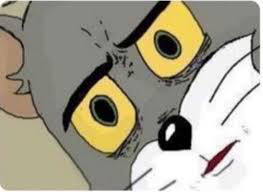

In [9]:
im2 = Image.open('/data/tom.jpeg')
#im2.convert("RGB")
im2

In [10]:
im2_data = np.array(im2)
im2_data.shape

(192, 263, 3)

In [11]:
im2_unique_color = np.unique(im2_data.reshape(-1, im2_data.shape[2]), axis=0)
print('Number of unique colors:', im2_unique_color.shape[0])
print('Number of channels:', im2_unique_color.shape[1])

im2_unique_color

Number of unique colors: 12462
Number of channels: 3


array([[  0,   0,   0],
       [  0,   0,   2],
       [  0,   0,   4],
       ...,
       [255, 255, 251],
       [255, 255, 253],
       [255, 255, 255]], dtype=uint8)

finding 5 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[ 40.92603059  35.15957447  28.12400266]
 [182.34386675 175.09993773 146.91796389]
 [236.77817135 207.24463139 104.13991587]
 [247.09252639 246.67794497 246.64677031]
 [132.23695955 130.06968852 121.54049279]]


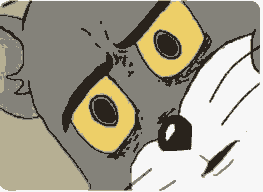

In [12]:
# down sample image
new_im2, new_rgbs2 = convert_image(im2, ncolors = 5)
new_im2

# Image 3

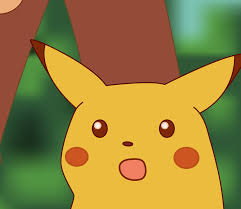

In [13]:
im3 = Image.open('/data/pikachu.jpeg')
im3

In [14]:
im3_data = np.array(im3)
im3_data.shape

(209, 241, 3)

In [15]:
im3_unique_color = np.unique(im3_data.reshape(-1, im3_data.shape[2]), axis=0)
print('Number of unique colors:', im3_unique_color.shape[0])
print('Number of channels:', im3_unique_color.shape[1])

im3_unique_color

Number of unique colors: 10738
Number of channels: 3


array([[  9,  65,  30],
       [ 15,  58,  30],
       [ 17,  95,  47],
       ...,
       [255, 243, 244],
       [255, 244, 216],
       [255, 253, 218]], dtype=uint8)

finding 5 most common colors.  Note, if "ncolors" is large, this can take a while...
Done finding colors! cluster centres in RGB:
 [[ 49.56202685  85.41728071  48.82265065]
 [148.70231414  73.52548628  50.52433305]
 [ 73.63378755 133.96701765  65.24992258]
 [110.39629408 178.03227735 144.65750149]
 [235.89510453 186.29227903  64.13697992]]


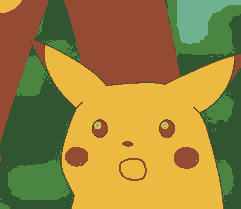

In [16]:
# down sample image

new_im3, new_rgbs3 = convert_image(im3, ncolors = 5)
new_im3

# Plot Colors in Images

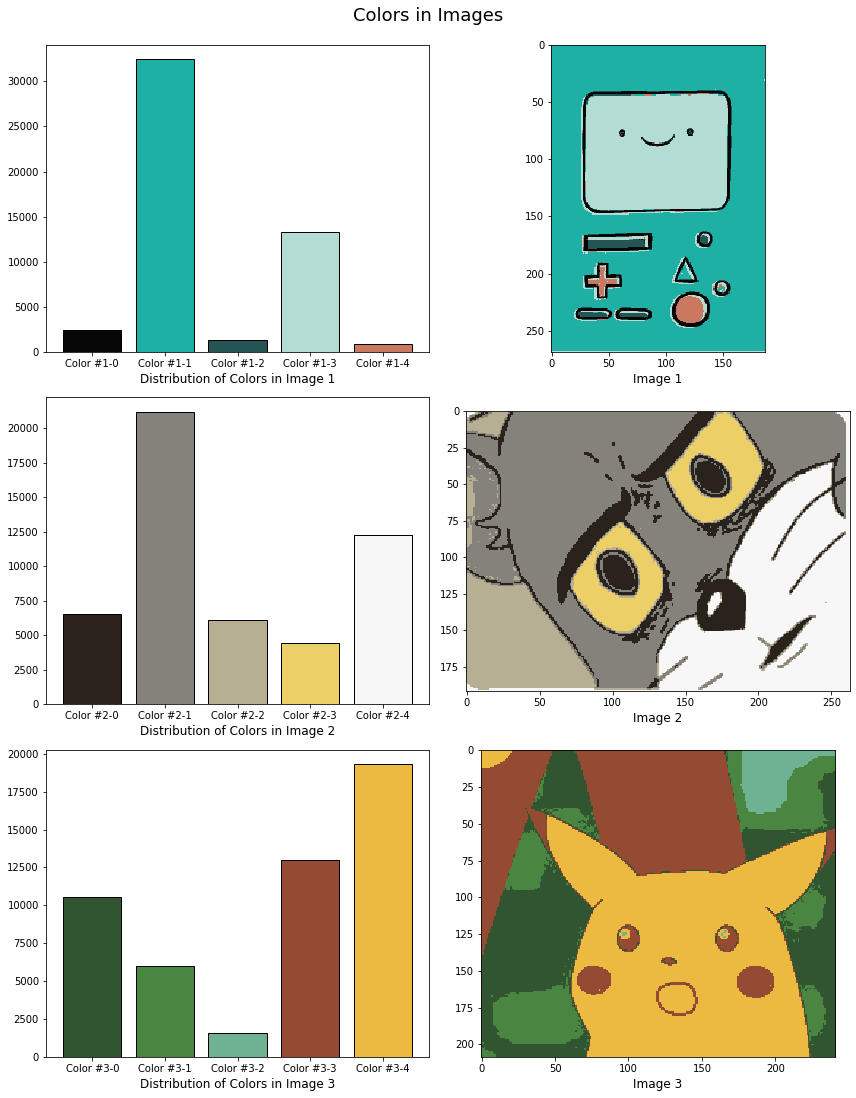

In [17]:
new_im1_data = np.array(new_im1)
new_im2_data = np.array(new_im2)
new_im3_data = np.array(new_im3)

data_list = [new_im1_data, new_im2_data, new_im3_data]

plot_color_in_image(data_list)


# Writeup

#### Similarities   
My first impression of the images was that each image had one dominant color. Image one was green, image two was grey, and image three was yellow. The histograms partially confirmed the domination of the colors. Green (color 1-1) and grey (color 2-1) had the highest number of pixels in image 1 and image 2, respectively. However, the histogram of image 3 showed that yellow was not the dominant color. The sum of pixels of green-ish colors (color 3-0 and color 3-1) was about the same as the number of yellow pixels.   

#### Differences  
Image 1 almost looked like monochrome, while the other two images were more colorful. The bar graphs confirmed this observation. In the bar graph of image 1, three out of five colors were green-ish (color 1-1, color 1-2, and color 1-3). In contrast, the bar graph of the other two images showed that the colors in the graph were quite different from each other. In image 2, there were black, grays, yellow, and white. In image 3, there were greens, browns, and yellow.    

#### Reason of liking the images
From observing the bars in the graphs, I discovered that these images all have contrasting colors — for instance, green and red in image 1, and grey and yellow in image 2. The contrast caught my attention and drove me to choose them.  

# Issues with functions for down sampling colors

#### Common issue:   
The information of "opaque" would be missing.

#### Issue with the first function:
This method worked because similar colors had similar RGB values. It looked that this function used k-mean to cluster the RBG information of the graph and used RGB values of centroids as the sampled colors. However, similar to any clustering problem, sometimes the boundaries of the data points were unclear. In the scenario that colors in the graphs were very close, the clusters might fail to capture the actual conditions. For example, in image 3 (the Picachu image), the Picachu's eyeballs were white but were classified as green in the down-sampled graph. The color of Picachu's mouth was initially red but became yellow after down-sampling. Another example was image 1 (the BMO image). In this image, BMO's orange button was clustered into the "red" cluster, and the blue button was clustered into one of the 'green' clusters.  
  
#### Issue with the second function:    
This method seemed like using numpy interp( ) and linespace( ) to align the RGB colors with the sample vectors. This method might have a distortion issue for the colors locating at the boundary between two intervals. Besides, colors were formed by the combination of R, G, and B. The inaccuracy of any RGB vectors might affect the sampled color. 